In [1]:
import torch
from torch import nn
import os
import numpy as np 
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import math
import statistics
import torchvision
from torchvision import transforms
from cv2 import cv2
from tqdm import tqdm
from PIL import Image
import csv

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class Sign_Dataset(Dataset):
    def __init__(self, file_path, data_type="train"):
      self.path = os.path.join(file_path, data_type)
      self.alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
      self.samples = self.get_samples()
      self.transform = transforms.Compose([
          transforms.RandAugment(),
          transforms.RandomAutocontrast(p=0.8),  
      ])
      
    def get_samples(self):
      samples = []
      for letter in tqdm(os.listdir(self.path)):
        target = self.alphabet.index(letter)
        letter_folder = os.path.join(self.path, letter)
        for image_path in os.listdir(letter_folder):
          if image_path.endswith('.png'):
            image = cv2.imread(os.path.join(self.path,letter,image_path))
            image_array = np.array(image)
            samples.append((image_array,target))
      return samples

    def __len__(self):
      return len(self.samples)
    
    def __getitem__(self, idx):
      image, target = self.samples[idx]
      image, target = torch.tensor(image), torch.tensor(target)
      image = image.permute(2,0,1).type(torch.uint8)
      image = self.transform(image)
      image = image.float()/255
      return (image, target)

In [4]:
image_path = "/content/drive/MyDrive/Colab Notebooks/Sign Language/images"

In [5]:
train_data = Sign_Dataset(image_path)

100%|██████████| 26/26 [01:00<00:00,  2.33s/it]


In [6]:
test_data = Sign_Dataset(image_path,data_type="test")

100%|██████████| 26/26 [04:12<00:00,  9.73s/it]


In [11]:
alphabet = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

In [8]:
print(len(train_data))
print(len(test_data))

3279
1069


In [9]:
def show_sample(data_set, grid_size=3, fig_size=9):
    rows, cols = grid_size, grid_size
    fig = plt.figure(figsize=(fig_size,fig_size))
    for i in range(1, rows*cols + 1):
        image, target = data_set[torch.randint(len(data_set),(1,)).tolist()[0]]
        image = image.permute(1,2,0).detach().cpu().numpy()
        fig.add_subplot(rows, cols, i)
        plt.imshow(image.squeeze())
        plt.axis('off')
        plt.title(alphabet[target])
    plt.show()

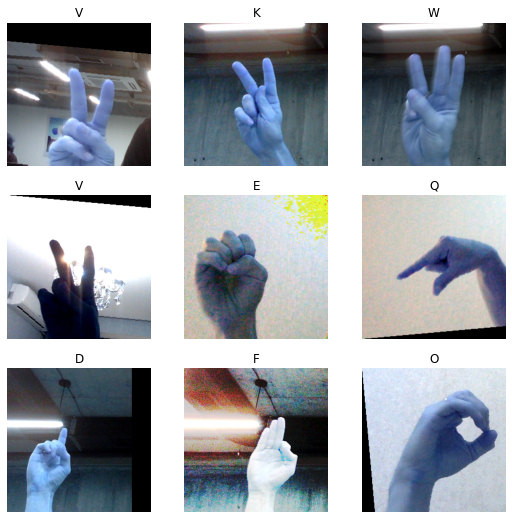

In [12]:
show_sample(train_data)

In [13]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=2),
            nn.Tanh(),
            nn.BatchNorm2d(6),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=2),
            nn.Tanh(),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=3, stride=2),
            nn.Tanh(),
            nn.BatchNorm2d(120),
            nn.Conv2d(in_channels=120, out_channels=120, kernel_size=3, padding=1, stride=2),
            nn.Tanh(),
            nn.BatchNorm2d(120),
            nn.Conv2d(in_channels=120, out_channels=120, kernel_size=3, padding=1, stride=2),
            nn.Tanh(),
            nn.BatchNorm2d(120),
            nn.Conv2d(in_channels=120, out_channels=120, kernel_size=3, padding=1, stride=1),
            nn.Tanh(),
            nn.BatchNorm2d(120),
            nn.Conv2d(in_channels=120, out_channels=120, kernel_size=3, padding=1, stride=1),
            nn.Tanh(),
            nn.BatchNorm2d(120),
            nn.Conv2d(in_channels=120, out_channels=120, kernel_size=3, padding=1, stride=1),
            nn.Tanh(),
            nn.BatchNorm2d(120),
            nn.Conv2d(in_channels=120, out_channels=120, kernel_size=3, padding=1, stride=1),
            nn.Tanh(),
            nn.BatchNorm2d(120),
            nn.Conv2d(in_channels=120, out_channels=120, kernel_size=3, padding=1, stride=1),
            nn.Tanh(),
            nn.BatchNorm2d(120),
            nn.Conv2d(in_channels=120, out_channels=64, kernel_size=3, stride=2),
            nn.Tanh(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=26, kernel_size=3, stride=2),
        )
    
    def forward(self, x):
        out = self.convnet(x)
        return out.squeeze()

In [14]:
def plot_losses(losses):
    fig = plt.figure()
    plt.plot(losses)

In [15]:
def calculate_accuracy(train_dataloader, model):
    train_accuracy = []
    for batch, (X,Y) in enumerate(train_dataloader):
        X, Y = X.to(device), Y.to(device)
        X_pred = model(X)
        train_accuracy.append(torch.where(X_pred.argmax(dim=-1) - Y == 0,1,0).float().mean().cpu().tolist())
    train_accuracy = statistics.mean(train_accuracy)
    return train_accuracy

In [16]:
def train_one(train_dataloader, model, optimiser):
    X, Y = next(iter(train_dataloader))
    losses = []
    for iteration in range(100):
        X, Y = X.to(device), Y.to(device)
        optimiser.zero_grad()
        X_pred = model(X)
        loss = loss_fn(X_pred,Y)
        loss.backward()
        optimiser.step()
        losses.append(loss.detach().cpu().numpy())
    plot_losses(losses)

In [17]:
def train(train_dataloader, model, optimiser):
    losses = []
    for epoch in range(EPOCHS):
        for batch, (X,Y) in enumerate(train_dataloader):
            X, Y = X.to(device), Y.to(device)
            optimiser.zero_grad()
            X_pred = model(X)
            loss = loss_fn(X_pred,Y)
            loss.backward()
            optimiser.step()
            losses.append(loss.detach().cpu().numpy())
        train_ac = calculate_accuracy(train_dataloader, model)
        print(f'Epoch {epoch+1}/{EPOCHS}: Train Accuracy: {train_ac}')
    plot_losses(losses)

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
bs = 64
lr = 0.0001
print(device)

cuda


In [19]:
train_dataloader = DataLoader(train_data,batch_size=bs,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=bs,shuffle=True)

In [20]:
model = Model().to(device)

In [21]:
# Load pre-trained weights
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Sign Language/'+'model_weights.pt', map_location=torch.device(device)))

<All keys matched successfully>

In [22]:
test_x = torch.rand(bs,3,256,256).to(device)
test_y = model(test_x)
test_y.size()

torch.Size([64, 26])

In [23]:
optimiser = torch.optim.Adam(model.parameters(),lr=lr)
loss_fn = nn.CrossEntropyLoss()

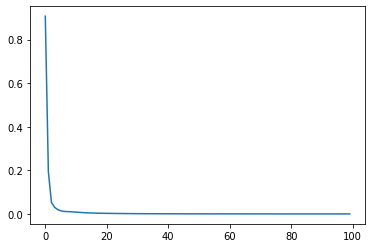

In [30]:
train_one(train_dataloader, model, optimiser)

Epoch 1/5: Train Accuracy: 0.9680689114790696
Epoch 2/5: Train Accuracy: 0.9719751614790696
Epoch 3/5: Train Accuracy: 0.9743790076329157
Epoch 4/5: Train Accuracy: 0.9597355769230769
Epoch 5/5: Train Accuracy: 0.96875


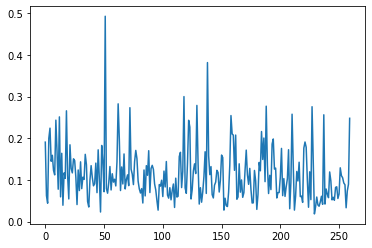

In [24]:
EPOCHS = 5
train(train_dataloader, model, optimiser)

In [25]:
torch.save(model.state_dict(),'/content/drive/MyDrive/Colab Notebooks/Sign Language/'+'model_weights.pt')

In [26]:
test_accuracy = []
for batch, (X,Y) in enumerate(test_dataloader):
    X, Y = X.to(device), Y.to(device)
    X_pred = model(X)
    test_accuracy.append(torch.where(X_pred.argmax(dim=-1) - Y == 0,1,0).float().mean().cpu().tolist())
test_accuracy = statistics.mean(test_accuracy)
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.9243872551357045


In [27]:
def show_predictions(model,data_set, grid_size=3, fig_size=9):
    rows, cols = grid_size, grid_size
    fig = plt.figure(figsize=(fig_size,fig_size))
    for i in range(1, rows*cols + 1):
        image, target = data_set[torch.randint(len(data_set),(1,)).tolist()[0]]
        pred = model(image.unsqueeze(0).to(device)).argmax().tolist()
        fig.add_subplot(rows, cols, i)
        plt.imshow(image.squeeze().permute(1,2,0))
        plt.axis('off')
        plt.title(f'prediction:{alphabet[pred]}, target:{alphabet[target]}')
    plt.show()

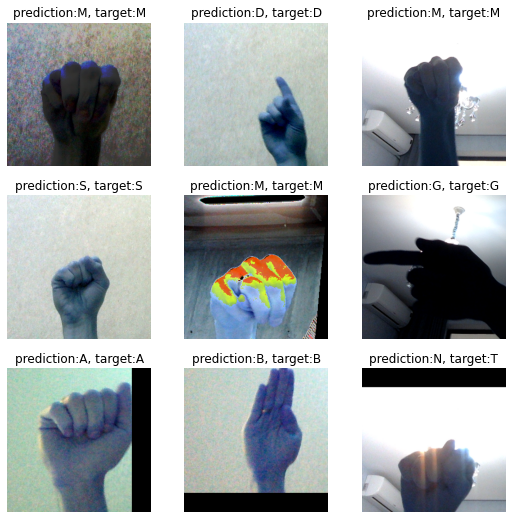

In [39]:
show_predictions(model,test_data)